### Precursor: postage stamp plot 
aka the Super position of forced signal and internal variability: Total
should look like 50 year trends of KGP for each ensemble member

see this notebook: https://github.com/NCAR/ncar-python-tutorial/blob/master/notebooks/workflows/cesm/oxygen-trend-computation/O2_forced_unforced.ipynb

## Figure 2: explicit signal decomposition

* take the two ensemble members from the postage stamp plot, one where natural variability is amplifying and one where it's dampening
* make the two row three column plot showing the decomposition of the total trend in each of those ensemble members.

##### Using the DJF prospective trends:
* Plot internal var and forced trend the two ensembles 
* Plot a replicate of the total signal where you are doing: this total signal is equal to this natural variability component plus this forced trend component.



In [1]:
%matplotlib inline
import os
import shutil

from itertools import product
import xpersist as xp
from glob import glob

import numpy as np
import xarray as xr

import pop_tools
import intake

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

In [2]:
ds_prosp = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf-prospective-trends.zarr')
ds_prosp

<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 2)
Coordinates:
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length        (length) float64 20.0 40.0 60.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 50
  * trend_year    (trend_year) int64 2006 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 3, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

Pick a prospective trend:


In [3]:
kgptrend_20_10 = ds_prosp['KGP'].sel(trend_length = 10, trend_year = 2020, length = 40. )
kgptrend_20_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2020, length = 40. )
kgptrend_20_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2020, length = 40. )

ssttrend_20_10 = ds_prosp['SST'].sel(trend_length = 10, trend_year = 2020 )
ssttrend_20_20 = ds_prosp['SST'].sel(trend_length = 20, trend_year = 2020 )
ssttrend_20_50 = ds_prosp['SST'].sel(trend_length = 50, trend_year = 2020 )

chltrend_20_10 = ds_prosp['Chl_surf'].sel(trend_length = 10, trend_year = 2020 )
chltrend_20_20 = ds_prosp['Chl_surf'].sel(trend_length = 20, trend_year = 2020 )
chltrend_20_50 = ds_prosp['Chl_surf'].sel(trend_length = 50, trend_year = 2020 )

Pick out the ensemble members with the min and max trends.

In [4]:
trnd_ds = kgptrend_20_50

member_id_pick = [
    trnd_ds.where(trnd_ds == trnd_ds.max(),
                     drop=True).member_id.values.astype('int')[0],
    trnd_ds.where(trnd_ds == trnd_ds.min(),
                     drop=True).member_id.values.astype('int')[0]
]
member_id_pick

[27, 16]

#### Make dataset plottable

In [5]:
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'trend': trnd_ds,
        'TLAT': trnd_ds.TLAT.compute(),
        'TLONG': trnd_ds.TLONG.compute()
    } ))
#dsp

#### Compute the forced (ensemble mean) and internal components. 
Call compute on these dataset to trigger loading into memory so that subsequent plotting operations proceed as rapidly as possible.

In [6]:
forced = dsp.trend.mean('member_id').compute()
internal = [(dsp.trend.sel(member_id=i) - forced).compute()
            for i in member_id_pick]

#forced

## Start here to reset the data you are plotting:

In [56]:
############## QUICK PLOTTING RESET Part 1 ##############
# VAR+trend_startyear_trendlength
trnd_ds = kgptrend_20_20

In [57]:
############## QUICK PLOTTING RESET Part 2 ##############
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'trend': trnd_ds,
        'TLAT': trnd_ds.TLAT.compute(),
        'TLONG': trnd_ds.TLONG.compute()
    } ))

In [58]:
############## QUICK PLOTTING RESET Part 3 ##############

# specify the exact EM number you want
test = [13,26]
# Recalc the trends
forced = dsp.trend.mean('member_id').compute()
internal = [(dsp.trend.sel(member_id=i) - forced).compute()
            #for i in member_id_pick]
            for i in test]


### Set up plotting 

In [59]:
#levels
limYMin = -0.006
limYMax = 0.006
levels = np.linspace(limYMin, limYMax, 15)
levels

array([-0.006     , -0.00514286, -0.00428571, -0.00342857, -0.00257143,
       -0.00171429, -0.00085714,  0.        ,  0.00085714,  0.00171429,
        0.00257143,  0.00342857,  0.00428571,  0.00514286,  0.006     ])

In [60]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
norm = MidpointNormalize(midpoint=0.)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()

### Define a helper function that makes a single map plot.


In [61]:
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     da,
                     levels=levels,
                     norm=norm,
                     cmap=cmocean.cm.curl_r,
                     #extend='both',
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG,
                    dsp.TLAT,
                    da,
                    colors='k',
                    #levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())

    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r')

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical',
                                            'land',
                                            '110m',
                                            facecolor='darkgray'))

    ax.coastlines(linewidth=0.5)

    return cf


#### Make a plot showing the Total trend and it's internal and forced components for the ensemble members with the min and max


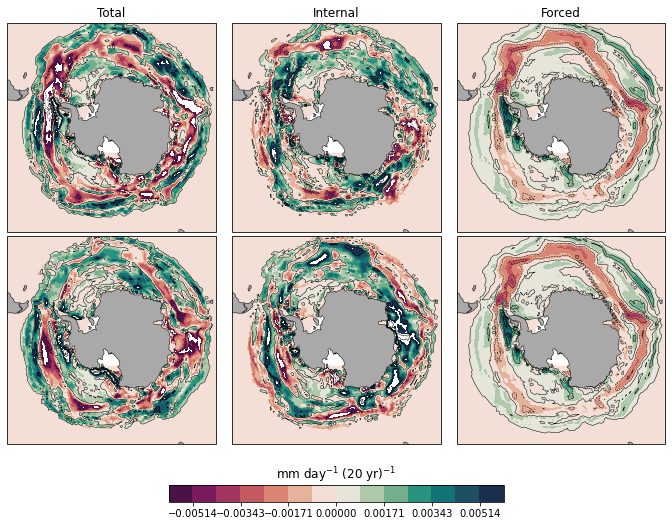

In [62]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(2, 3, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(dsp.trend.sel(member_id=member_id_pick[0]))
#ax.text(235., 60, f'{member_id_pick[0]:03d}', transform=ccrs.PlateCarree())
ax.set_title('Total')
axs.append(ax)

ax = fig.add_subplot(2, 3, 4, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(dsp.trend.sel(member_id=member_id_pick[1]))
#ax.text(235., 60, f'{member_id_pick[1]:03d}', transform=ccrs.PlateCarree())
axs.append(ax)

# plot internal variability
ax = fig.add_subplot(2, 3, 2, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(internal[0])
#ax.text(235., 60, f'{member_id_pick[0]:03d}', transform=ccrs.PlateCarree())
ax.set_title('Internal')
axs.append(ax)

ax = fig.add_subplot(2, 3, 5, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(internal[1])
#ax.text(235., 60, f'{member_id_pick[1]:03d}', transform=ccrs.PlateCarree())
axs.append(ax)

# plot forced
ax = fig.add_subplot(2, 3, 3, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(forced)
ax.set_title('Forced')
axs.append(ax)

ax = fig.add_subplot(2, 3, 6, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(forced)
axs.append(ax)

# add colorbar
plt.subplots_adjust(hspace=0.02, wspace=0.02)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', ax=axs, pad=0.075)

cb.ax.set_title('mm day$^{-1}$ (20 yr)$^{-1}$ ')

#save figure
plt.savefig('figures/mapped trends/decomposition/trend-decomp-KGP-20yr-2020-13and26-level.pdf', bbox_inches='tight')

___
### postage stamp plot showing all the trends: 
First compute each ensemble member to load into memory.

In [2]:
field = [
    dsp.trend.isel(member_id=i).compute() for i in range(0, len(ds_prosp.member_id))
]

NameError: name 'ds_prosp' is not defined

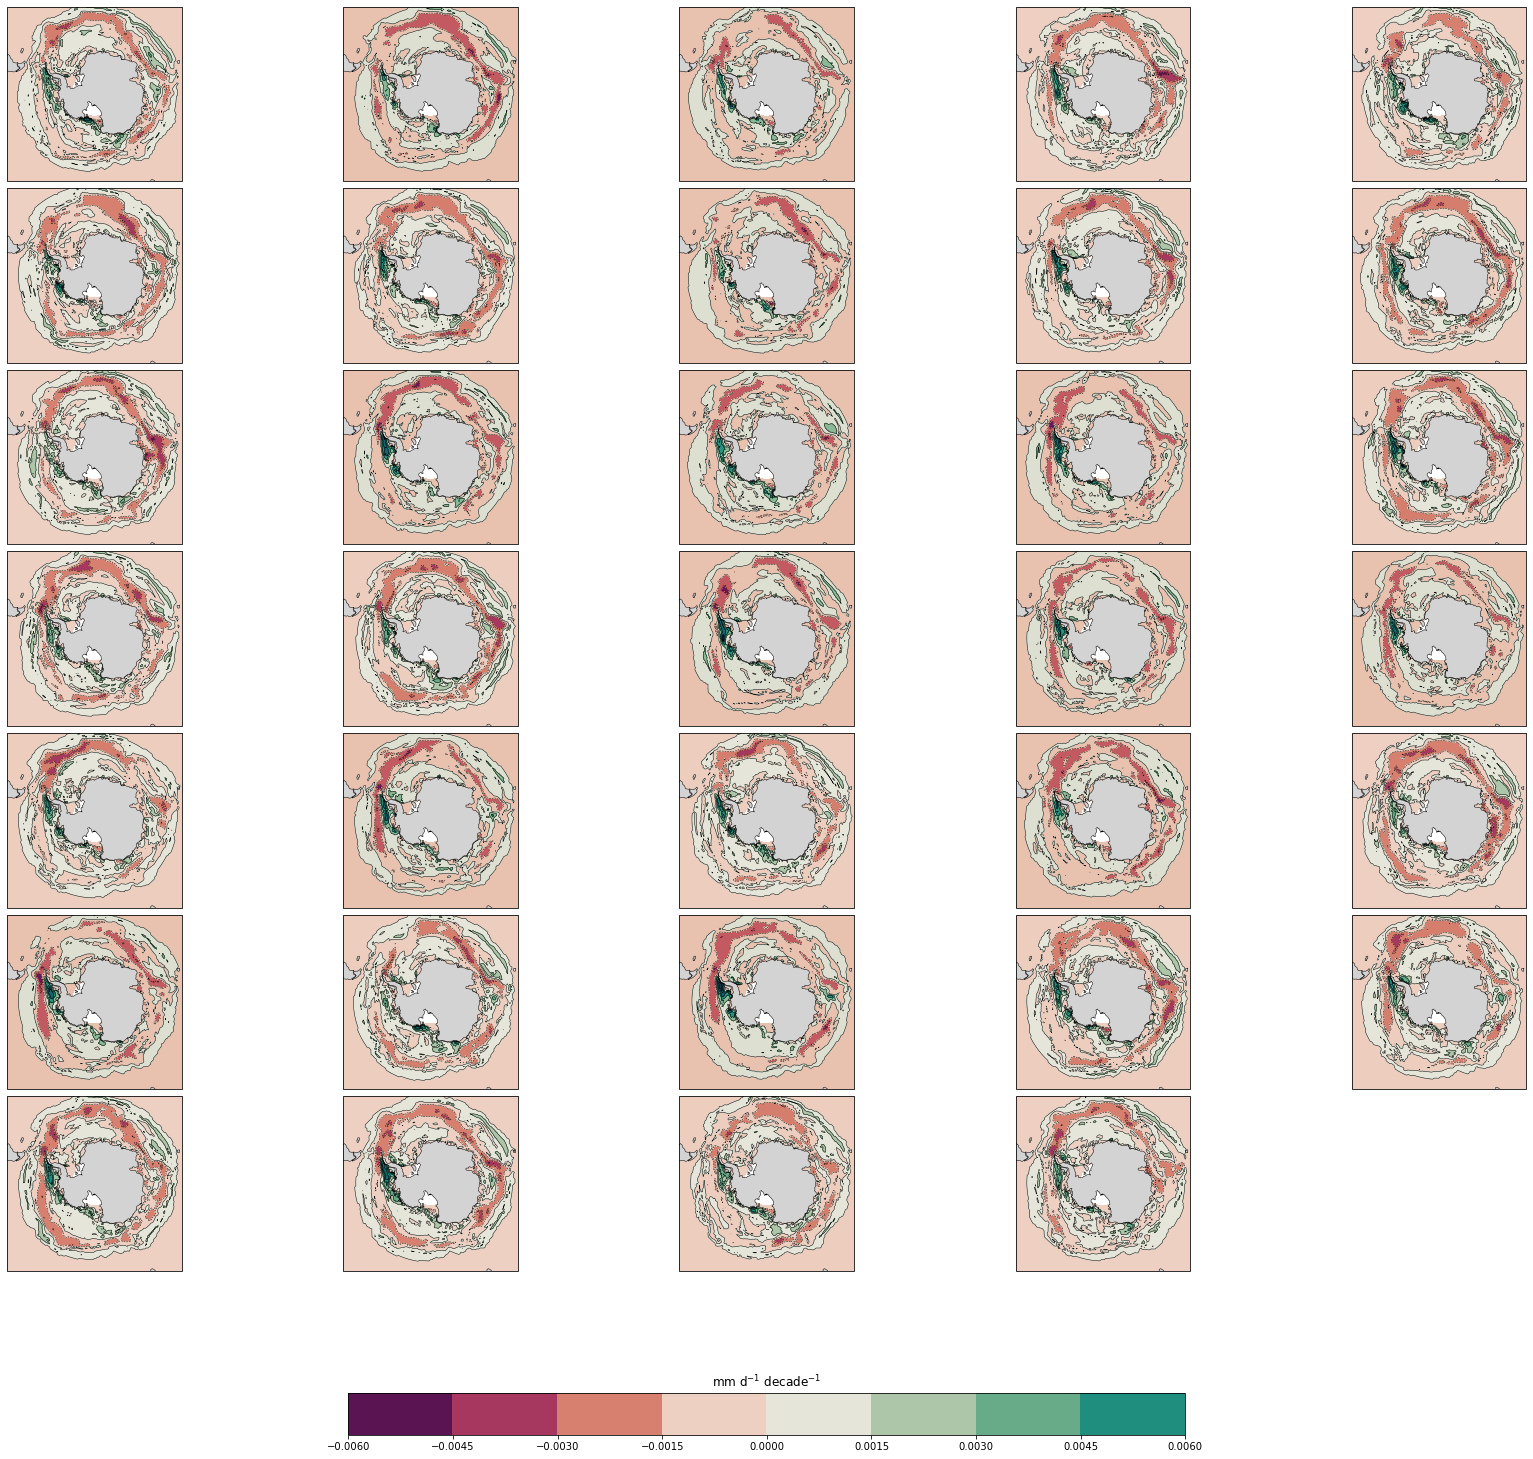

In [49]:
fig = plt.figure(figsize=(30, 30))

axs = []

# plot total
for i in range(0, len(ds_prosp.member_id)):
    ax = fig.add_subplot(7, 5, i + 1, projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    cf = one_plot(field[i], lines = False)
    axs.append(ax)

plt.subplots_adjust(hspace=0.04, wspace=0.02)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', ax=axs, pad=0.075)
cb.ax.set_title(dsp.trend.units)

plt.savefig('figures/all-trends-KGP-2006-50yr-lines-100dpi.png', dpi=100, bbox_inches='tight')

### Plot All Trends - Internal

Text(0.5, 1.0, 'mm d$^{-1}$ decade$^{-1}$')

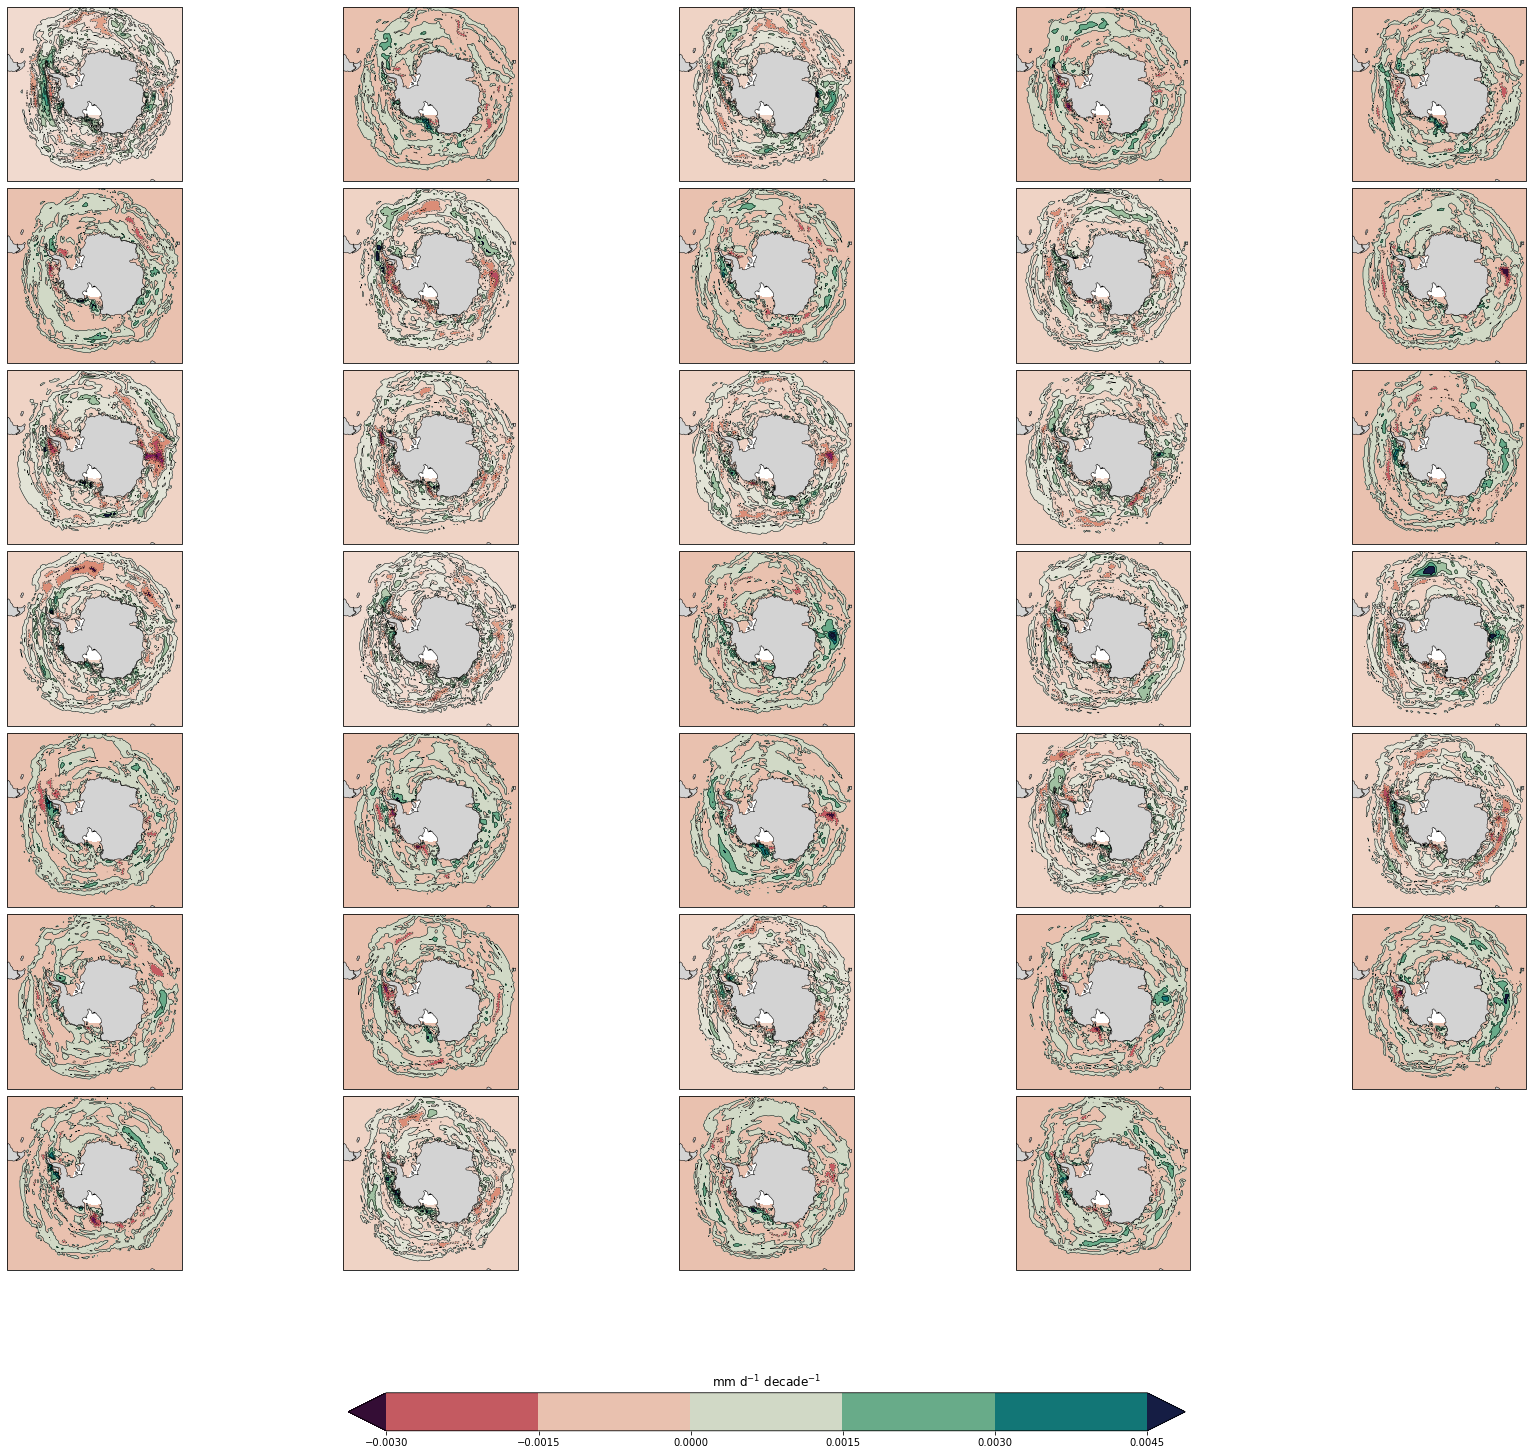

In [79]:
fig = plt.figure(figsize=(30, 30))

axs = []

# plot total
for i in range(0, len(ds_prosp.member_id)):
    ax = fig.add_subplot(7, 5, i + 1, projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    cf = one_plot(field[i] - forced, lines=False)
    axs.append(ax)

plt.subplots_adjust(hspace=0.04, wspace=0.02)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', ax=axs, pad=0.075)
cb.ax.set_title(dsp.trend.units)

#plt.savefig('figures/all-trends-internal-KGP-2006-50yr-100dpi.png', dpi=100, bbox_inches='tight')

## Try to stipple:

In [33]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.test,lines = False)
ax.set_title('1920-1950')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Growth Potential (mm day$^{-1}$)')
plt.savefig('figures/epochs/1920-1950-mean-KGP.png')#, dpi=300, bbox_inches='tight')

# add colorbar
#plt.subplots_adjust(hspace=0.02, wspace=0.02)
